# Benchmark: MBR computation

Benchmark comparing Minimum Bounding Rectangle computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the Minimum Bounding Rectangle of the multi-polygon representing all districts of India a 100,000 times.

## WARNING

The analysis below shows that GEOS precomputes envolveop and is therefore faster...

# Prerequisites

Generate data:

```sh
cd harness
cargo run --release --bin benchmark_mbr -- --out-file ../analysis/benchmark_mbr/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson --iterations 300 --headlong
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_mbr/data.json
### Statistics: Raw data
                 qps                                              
program          geo          geos    geos_twice geos_twice_cloned
count     200.000000    200.000000    200.000000        200.000000
mean     4398.970472  52089.122950  24493.907862      24833.656598
std      1427.234378  11932.371373   8086.903920       7666.648353
min      1373.773881   6025.079526   4629.476064       2234.142125
25%      3290.333922  54818.077027  27738.522468      27663.347849
50%      5568.125174  55764.150666  28206.765890      28004.190934
75%      5651.937510  56086.735107  28398.313475      28202.576821
max      5694.596338  57027.703545  28647.756836      28480.105080


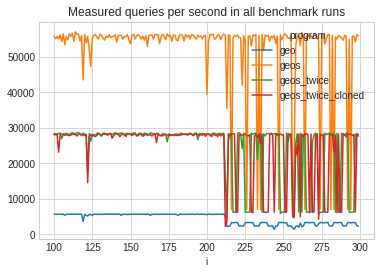

### Statistics: After outlier removal
                 qps                                              
program          geo          geos    geos_twice geos_twice_cloned
count     141.000000    141.000000    141.000000        141.000000
mean     4932.686119  55185.749600  28048.429730      27806.002052
std      1339.924508   2293.385267   1079.031645       1346.060251
min      2202.563166  39347.584005  17480.746793      14559.467000
25%      5332.211521  54981.802123  28063.789892      27845.041343
50%      5637.450962  55801.734206  28276.284751      28068.978617
75%      5662.239990  56103.392718  28409.634082      28220.121121
max      5694.596338  57027.703545  28647.756836      28480.105080


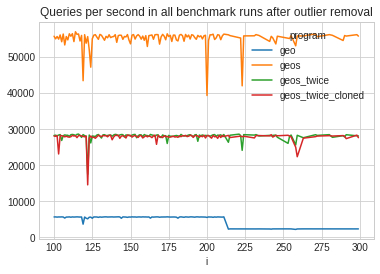

## Ratio of qps compared to geo
                qps                              
program        geos  geos_twice geos_twice_cloned
count    141.000000  141.000000        141.000000
mean      12.685127    6.443030          6.392665
std        5.611693    2.824596          2.827649
min        7.116664    3.398322          2.830414
25%        9.822308    4.988590          4.942570
50%        9.917329    5.022956          4.989856
75%       10.139926    5.271806          5.204016
max       24.600042   12.324267         12.469031


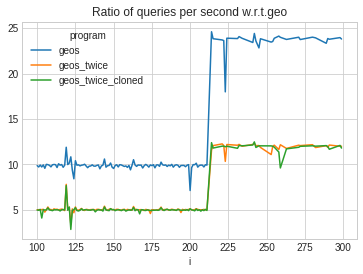

In [3]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb

# Performance benchmarking

To generate the following SVG:

```bash
cd harness
cargo build --release

perf record -F 990 -g -o ../analysis/benchmark_mbr/perf.data -- ./target/release/benchmark_mbr --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 200 --headlong > /dev/null

cd ../analysis/benchmark_mbr
perf script -i perf.data | ../../third_party/stackcollapse-perf.pl > perf.collapsed-stacks.data
../../third_party/flamegraph.pl perf.collapsed-stacks.data > perf.svg
```

![](./perf.svg)

To dig in further, use
```
perf report -g -i perf.data
```

This shows that over 90% time is spent in `geo_types::private_utils::get_bounding_rect`.

In particular, `getEnvelope` in `libgeos` contributes ~0.13% time: ![](./ReportGetEnvelope.png)

-> My assumption that geo is losing out due to bad memory allocations is wrong.